### Phase 1 Small Grid Test

Loaded 600 runs.


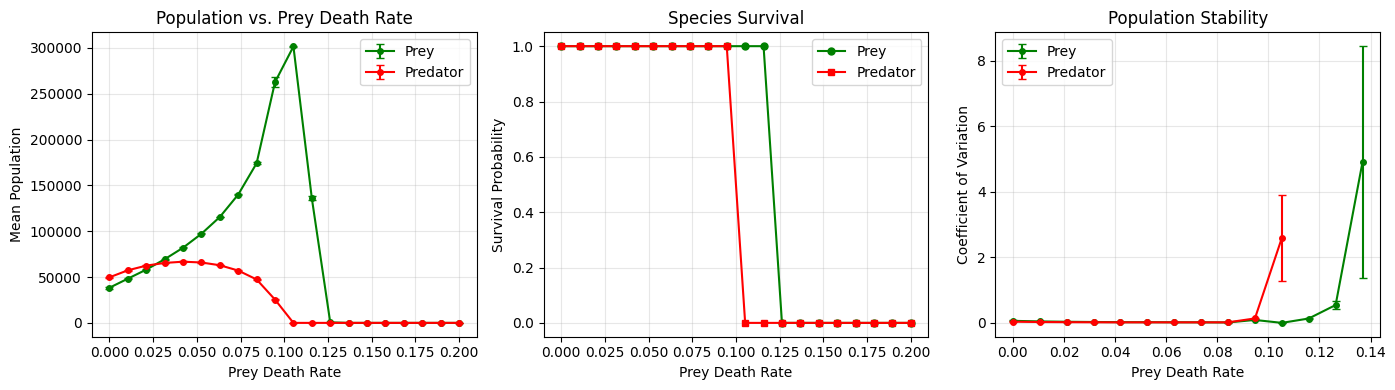

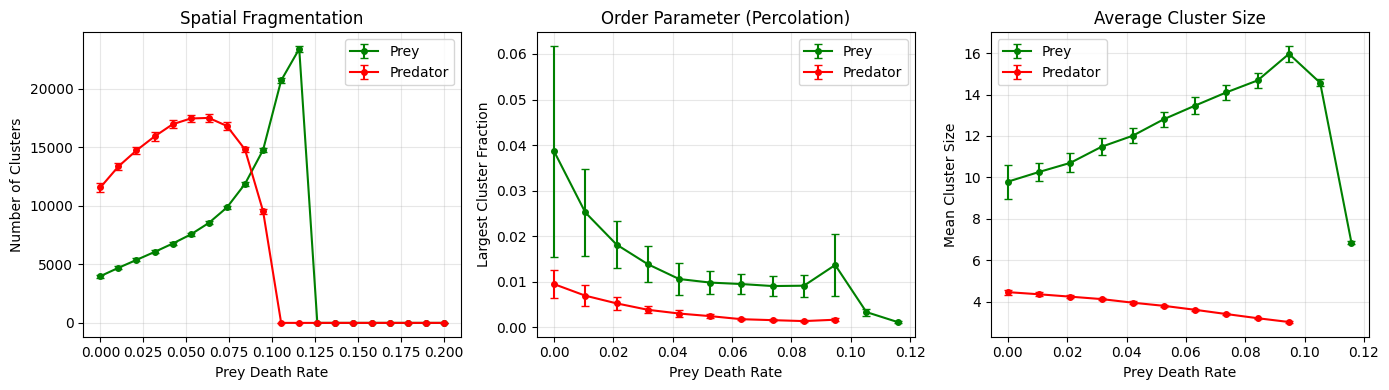

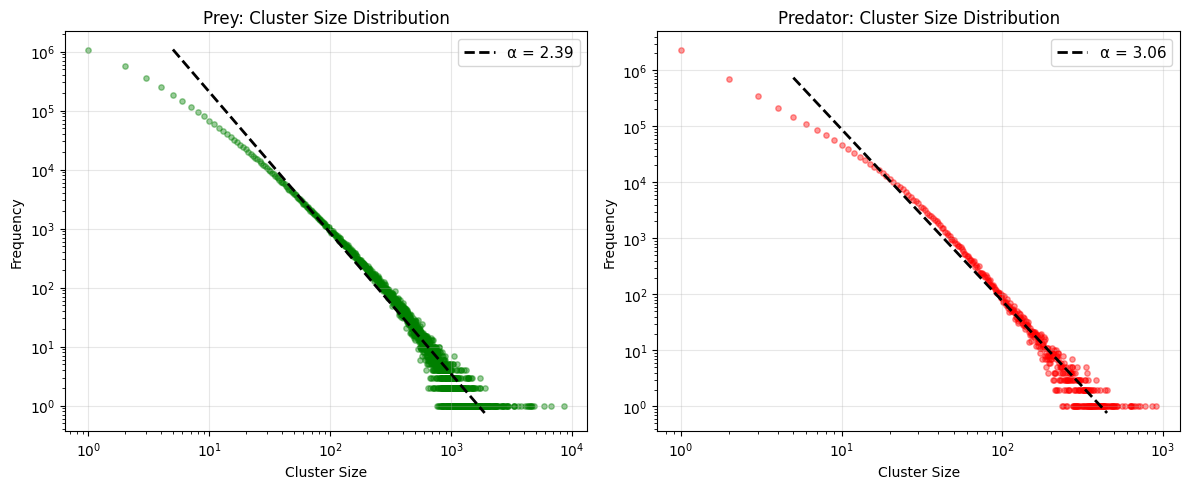

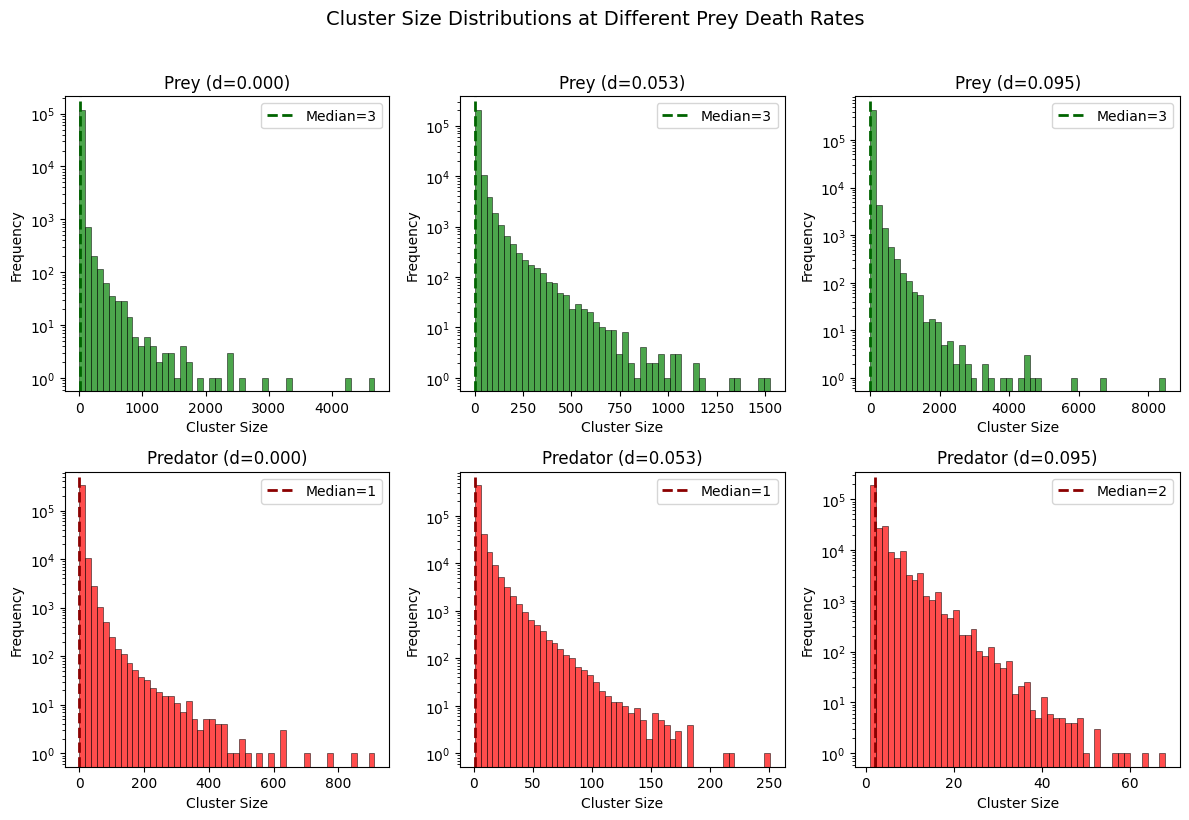

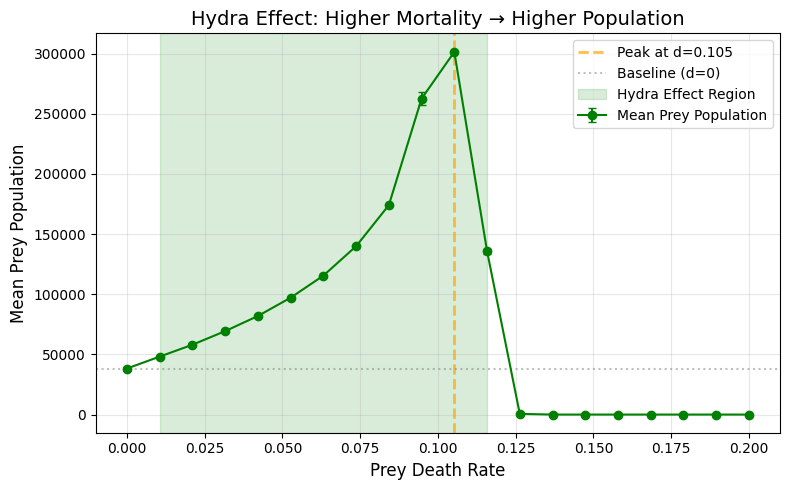


PHASE 1 SUMMARY

Total simulations: 600
Prey death range: [0.000, 0.200]
Replicates per condition: 30

Hydra Effect:
  Baseline prey pop (d=0): 38,288
  Peak prey pop: 301,450 at d=0.105
  Increase: 687.3%

Critical Transitions:
  Predator extinction threshold: d ≈ 0.105
  Prey extinction threshold: d ≈ 0.126


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast

# --- 1. Data Loading ---
def load_results(filepath):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            try:
                entry = json.loads(line)
                data.append(entry)
            except json.JSONDecodeError:
                print(f"Skipping invalid line: {line[:50]}...")
                continue
    return pd.DataFrame(data)

df = load_results('../phase1_18677015/phase1_results.jsonl')
print(f"Loaded {len(df)} runs.")

# --- 2. Parse cluster sizes ---
def parse_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x) or x == '[]':
        return []
    try:
        return ast.literal_eval(x)
    except:
        return []

df['prey_clusters_parsed'] = df['prey_cluster_sizes'].apply(parse_list)
df['pred_clusters_parsed'] = df['pred_cluster_sizes'].apply(parse_list)

# =============================================================================
# FIGURE 1: Population Dynamics vs Prey Death Rate (Hydra Effect)
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1a. Mean populations
ax = axes[0]
for pop, label, color in [('prey_mean', 'Prey', 'green'), ('pred_mean', 'Predator', 'red')]:
    agg = df.groupby('prey_death')[pop].agg(['mean', 'std']).reset_index()
    ax.errorbar(agg['prey_death'], agg['mean'], yerr=agg['std'], 
                fmt='o-', capsize=3, label=label, color=color, markersize=4)
ax.set_xlabel('Prey Death Rate')
ax.set_ylabel('Mean Population')
ax.set_title('Population vs. Prey Death Rate')
ax.legend()
ax.grid(True, alpha=0.3)

# 1b. Survival probability
ax = axes[1]
surv = df.groupby('prey_death').agg({
    'prey_survived': 'mean',
    'pred_survived': 'mean'
}).reset_index()
ax.plot(surv['prey_death'], surv['prey_survived'], 'o-', color='green', label='Prey', markersize=5)
ax.plot(surv['prey_death'], surv['pred_survived'], 's-', color='red', label='Predator', markersize=5)
ax.set_xlabel('Prey Death Rate')
ax.set_ylabel('Survival Probability')
ax.set_title('Species Survival')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

# 1c. Coefficient of variation (stability)
ax = axes[2]
df['prey_cv'] = df['prey_std'] / df['prey_mean'].replace(0, np.nan)
df['pred_cv'] = df['pred_std'] / df['pred_mean'].replace(0, np.nan)
for col, label, color in [('prey_cv', 'Prey', 'green'), ('pred_cv', 'Predator', 'red')]:
    agg = df.groupby('prey_death')[col].agg(['mean', 'std']).reset_index()
    ax.errorbar(agg['prey_death'], agg['mean'], yerr=agg['std'], 
                fmt='o-', capsize=3, label=label, color=color, markersize=4)
ax.set_xlabel('Prey Death Rate')
ax.set_ylabel('Coefficient of Variation')
ax.set_title('Population Stability')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig1_population_dynamics.png', dpi=150)
plt.show()

# =============================================================================
# FIGURE 2: Cluster Statistics vs Prey Death Rate
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 2a. Number of clusters
ax = axes[0]
for col, label, color in [('prey_n_clusters', 'Prey', 'green'), ('pred_n_clusters', 'Predator', 'red')]:
    agg = df.groupby('prey_death')[col].agg(['mean', 'std']).reset_index()
    ax.errorbar(agg['prey_death'], agg['mean'], yerr=agg['std'], 
                fmt='o-', capsize=3, label=label, color=color, markersize=4)
ax.set_xlabel('Prey Death Rate')
ax.set_ylabel('Number of Clusters')
ax.set_title('Spatial Fragmentation')
ax.legend()
ax.grid(True, alpha=0.3)

# 2b. Largest cluster fraction (order parameter)
ax = axes[1]
for col, label, color in [('prey_largest_fraction', 'Prey', 'green'), ('pred_largest_fraction', 'Predator', 'red')]:
    agg = df.groupby('prey_death')[col].agg(['mean', 'std']).reset_index()
    ax.errorbar(agg['prey_death'], agg['mean'], yerr=agg['std'], 
                fmt='o-', capsize=3, label=label, color=color, markersize=4)
ax.set_xlabel('Prey Death Rate')
ax.set_ylabel('Largest Cluster Fraction')
ax.set_title('Order Parameter (Percolation)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2c. Mean cluster size
df['prey_mean_cluster'] = df['prey_clusters_parsed'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
df['pred_mean_cluster'] = df['pred_clusters_parsed'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
ax = axes[2]
for col, label, color in [('prey_mean_cluster', 'Prey', 'green'), ('pred_mean_cluster', 'Predator', 'red')]:
    agg = df.groupby('prey_death')[col].agg(['mean', 'std']).reset_index()
    ax.errorbar(agg['prey_death'], agg['mean'], yerr=agg['std'], 
                fmt='o-', capsize=3, label=label, color=color, markersize=4)
ax.set_xlabel('Prey Death Rate')
ax.set_ylabel('Mean Cluster Size')
ax.set_title('Average Cluster Size')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig2_cluster_statistics.png', dpi=150)
plt.show()

# =============================================================================
# FIGURE 3: Cluster Size Distributions (Power-law check)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (col, label, color) in zip(axes, [('prey_clusters_parsed', 'Prey', 'green'), 
                                           ('pred_clusters_parsed', 'Predator', 'red')]):
    # Aggregate all cluster sizes (only from surviving runs)
    all_sizes = np.array([s for sizes in df[col] for s in sizes if s > 0])
    
    if len(all_sizes) > 0:
        # Log-log histogram
        sizes, counts = np.unique(all_sizes, return_counts=True)
        ax.scatter(sizes, counts, alpha=0.4, color=color, s=15)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Cluster Size')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{label}: Cluster Size Distribution')
        ax.grid(True, alpha=0.3)
        
        # Power-law fit
        mask = (sizes >= 5) & (counts >= 2)
        if mask.sum() > 5:
            log_s, log_c = np.log10(sizes[mask]), np.log10(counts[mask])
            slope, intercept = np.polyfit(log_s, log_c, 1)
            fit_x = np.logspace(np.log10(sizes[mask].min()), np.log10(sizes[mask].max()), 50)
            fit_y = 10**intercept * fit_x**slope
            ax.plot(fit_x, fit_y, 'k--', lw=2, label=f'α = {-slope:.2f}')
            ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('fig3_cluster_powerlaw.png', dpi=150)
plt.show()

# =============================================================================
# FIGURE 4: Cluster Distributions at Different Death Rates
# =============================================================================
death_rates = sorted(df['prey_death'].unique())
# Select low, mid (before extinction), and high (near transition)
coexist_rates = [dr for dr in death_rates if df[df['prey_death']==dr]['pred_survived'].mean() > 0.5]
if len(coexist_rates) >= 3:
    selected_rates = [coexist_rates[0], coexist_rates[len(coexist_rates)//2], coexist_rates[-1]]
else:
    selected_rates = coexist_rates[:3] if coexist_rates else death_rates[:3]

fig, axes = plt.subplots(2, len(selected_rates), figsize=(4*len(selected_rates), 8))

for i, dr in enumerate(selected_rates):
    subset = df[df['prey_death'] == dr]
    
    # Prey
    ax = axes[0, i]
    all_prey = [s for sizes in subset['prey_clusters_parsed'] for s in sizes]
    if len(all_prey) > 0:
        ax.hist(all_prey, bins=50, color='green', alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axvline(np.median(all_prey), color='darkgreen', ls='--', lw=2, label=f'Median={np.median(all_prey):.0f}')
        ax.legend()
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Prey (d={dr:.3f})')
    ax.set_yscale('log')
    
    # Predator
    ax = axes[1, i]
    all_pred = [s for sizes in subset['pred_clusters_parsed'] for s in sizes]
    if len(all_pred) > 0:
        ax.hist(all_pred, bins=50, color='red', alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axvline(np.median(all_pred), color='darkred', ls='--', lw=2, label=f'Median={np.median(all_pred):.0f}')
        ax.legend()
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Predator (d={dr:.3f})')
    ax.set_yscale('log')

plt.suptitle('Cluster Size Distributions at Different Prey Death Rates', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('fig4_cluster_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# FIGURE 5: Hydra Effect Highlight
# =============================================================================
fig, ax = plt.subplots(figsize=(8, 5))

agg = df.groupby('prey_death')['prey_mean'].agg(['mean', 'std']).reset_index()

# Find peak
peak_idx = agg['mean'].idxmax()
peak_dr = agg.loc[peak_idx, 'prey_death']
peak_pop = agg.loc[peak_idx, 'mean']

ax.errorbar(agg['prey_death'], agg['mean'], yerr=agg['std'], 
            fmt='o-', capsize=3, color='green', markersize=6, label='Mean Prey Population')
ax.axvline(peak_dr, color='orange', ls='--', lw=2, alpha=0.7, label=f'Peak at d={peak_dr:.3f}')
ax.axhline(agg['mean'].iloc[0], color='gray', ls=':', alpha=0.5, label=f'Baseline (d=0)')

# Shade Hydra effect region
hydra_region = agg[agg['mean'] > agg['mean'].iloc[0]]
if len(hydra_region) > 0:
    ax.axvspan(hydra_region['prey_death'].min(), hydra_region['prey_death'].max(), 
               alpha=0.15, color='green', label='Hydra Effect Region')

ax.set_xlabel('Prey Death Rate', fontsize=12)
ax.set_ylabel('Mean Prey Population', fontsize=12)
ax.set_title('Hydra Effect: Higher Mortality → Higher Population', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig5_hydra_effect.png', dpi=150)
plt.show()

# =============================================================================
# SUMMARY STATISTICS
# =============================================================================
print("\n" + "="*60)
print("PHASE 1 SUMMARY")
print("="*60)

print(f"\nTotal simulations: {len(df)}")
print(f"Prey death range: [{df['prey_death'].min():.3f}, {df['prey_death'].max():.3f}]")
print(f"Replicates per condition: {df.groupby('prey_death').size().iloc[0]}")

# Hydra effect
baseline_pop = agg['mean'].iloc[0]
print(f"\nHydra Effect:")
print(f"  Baseline prey pop (d=0): {baseline_pop:,.0f}")
print(f"  Peak prey pop: {peak_pop:,.0f} at d={peak_dr:.3f}")
print(f"  Increase: {100*(peak_pop/baseline_pop - 1):.1f}%")

# Critical transitions
pred_extinct = df.groupby('prey_death')['pred_survived'].mean()
prey_extinct = df.groupby('prey_death')['prey_survived'].mean()

pred_crit = pred_extinct[pred_extinct < 0.5].index.min() if (pred_extinct < 0.5).any() else None
prey_crit = prey_extinct[prey_extinct < 0.5].index.min() if (prey_extinct < 0.5).any() else None

print(f"\nCritical Transitions:")
print(f"  Predator extinction threshold: d ≈ {pred_crit:.3f}" if pred_crit else "  Predators survive all conditions")
print(f"  Prey extinction threshold: d ≈ {prey_crit:.3f}" if prey_crit else "  Prey survive all conditions")

Selected death rates:
  d = 0.0526: prey_surv = 100%, pred_surv = 100%
  d = 0.0947: prey_surv = 100%, pred_surv = 100%
  d = 0.1158: prey_surv = 100%, pred_surv = 0%


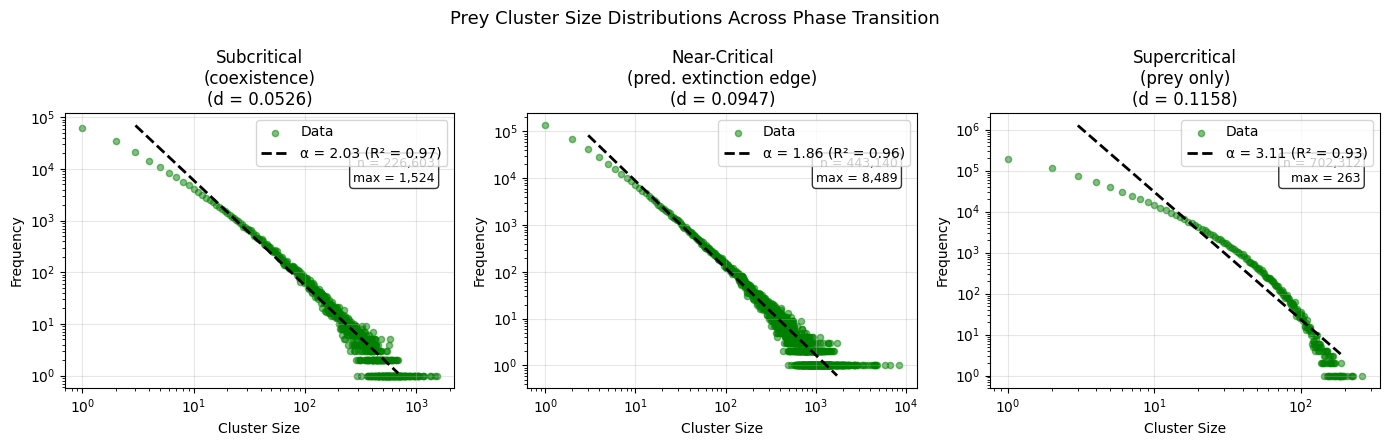

In [5]:
# =============================================================================
# Cluster Size Distributions Near Critical Point
# =============================================================================

# Based on your summary:
# - Predator extinction: d ≈ 0.105
# - Prey extinction: d ≈ 0.126
# - Peak Hydra effect: d = 0.105

death_rates = sorted(df['prey_death'].unique())

# Find closest values to our targets
def find_closest(target, values):
    return min(values, key=lambda x: abs(x - target))

subcritical = find_closest(0.05, death_rates)    # Well below critical
critical = find_closest(0.095, death_rates)       # Just before predator extinction
supercritical = find_closest(0.115, death_rates)  # After predator extinction, before prey extinction

selected = [subcritical, critical, supercritical]
labels = ['Subcritical\n(coexistence)', 'Near-Critical\n(pred. extinction edge)', 'Supercritical\n(prey only)']

print(f"Selected death rates:")
for lbl, dr in zip(labels, selected):
    n_prey = df[df['prey_death']==dr]['prey_survived'].mean()
    n_pred = df[df['prey_death']==dr]['pred_survived'].mean()
    print(f"  d = {dr:.4f}: prey_surv = {n_prey:.0%}, pred_surv = {n_pred:.0%}")

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))

for ax, dr, label in zip(axes, selected, labels):
    subset = df[df['prey_death'] == dr]
    
    # Collect all prey cluster sizes
    all_sizes = np.array([s for sizes in subset['prey_clusters_parsed'] for s in sizes if s > 0])
    
    if len(all_sizes) == 0:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, ha='center')
        ax.set_title(f'{label}\n(d = {dr:.4f})')
        continue
    
    # Compute frequency
    sizes, counts = np.unique(all_sizes, return_counts=True)
    
    # Plot
    ax.scatter(sizes, counts, alpha=0.5, color='green', s=20, label='Data')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{label}\n(d = {dr:.4f})')
    ax.grid(True, alpha=0.3)
    
    # Power-law fit
    mask = (sizes >= 3) & (counts >= 2)
    if mask.sum() > 5:
        log_s = np.log10(sizes[mask])
        log_c = np.log10(counts[mask])
        slope, intercept = np.polyfit(log_s, log_c, 1)
        
        # R²
        predicted = slope * log_s + intercept
        ss_res = np.sum((log_c - predicted) ** 2)
        ss_tot = np.sum((log_c - np.mean(log_c)) ** 2)
        r2 = 1 - ss_res / ss_tot
        
        fit_x = np.logspace(np.log10(sizes[mask].min()), np.log10(sizes[mask].max()), 50)
        fit_y = 10**intercept * fit_x**slope
        ax.plot(fit_x, fit_y, 'k--', lw=2, label=f'α = {-slope:.2f} (R² = {r2:.2f})')
        ax.legend(loc='upper right')
    
    # Stats box
    ax.text(0.95, 0.75, f'n = {len(all_sizes):,}\nmax = {all_sizes.max():,}', 
            transform=ax.transAxes, ha='right', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Prey Cluster Size Distributions Across Phase Transition', fontsize=13)
plt.tight_layout()
plt.savefig('cluster_distributions_critical.png', dpi=150, bbox_inches='tight')
plt.show()